**ideas**

*   slowly turn the robot until it's split (half and half)
*   use a linear regression model to determine how much to turn based on contour size
*   ...



In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage.color
from sklearn.linear_model import LinearRegression

In [3]:
def find_largest_contour(contours):
  largest = max(contours, key = cv2.contourArea)
  return largest

In [4]:
def bgr_to_rgb(image):
  return image[:,:,::-1]

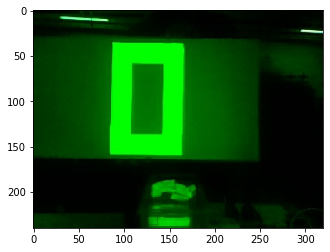

In [ ]:
img = cv2.imread("reflective.jpeg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# New Section

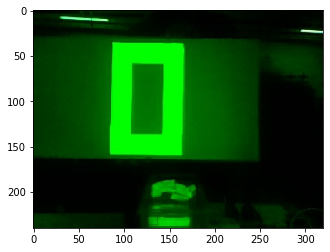

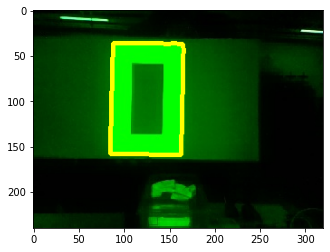

In [ ]:
img = cv2.imread("reflective.jpeg")
plt.imshow(img)
plt.show()

mask = cv2.threshold(cv2.imread("reflective.jpeg", cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY)[1]
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# # filtered_mask = cv2.medianBlur(mask, 11)
# contours2 = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = find_largest_contour(contours)

# plt.imshow(cv2.drawContours(img.copy(), contours, -1, (255,255,0), 3))
# plt.show()
plt.imshow(cv2.drawContours(img.copy(), [largest_contour], -1, (255,255,0), 3))
plt.show()

In [ ]:
pixel_buffer = 2
def align_with_hub(largest_contour):
  x,y,rect_w,rect_h = cv2.boundingRect(largest_contour)
  x_center = x + rect_w/2
  if x_center < img_w/2 + pixel_buffer:
    # move right
    print("move right")
    align_with_hub() # put new photo after moving robot
  elif x_center > img_w/2 - pixel_buffer:
    # move left
    print("move left")
    align_with_hub() # put new photo after moving robot
  else:
    print("ready to shoot")

In [ ]:
img_h, img_w, channels = img.shape
print(img_w)
align_with_hub(largest_contour)

320
move right


TypeError: ignored

# Code to run on Limelight

In [ ]:
import cv2
import numpy as np
# from matplotlib import pyplot as plt
import math
def find_largest_contour(contours):
   if(len(contours) > 0):
       largest = max(contours, key = cv2.contourArea)
       return largest
   return None
 
PIXEL_BUFFER = 30
img_w = 320
def align_with_hub(largest_contour):
  x,y,rect_w,rect_h = cv2.boundingRect(largest_contour)
  x_center = x + rect_w/2
  if x_center < img_w/2 + PIXEL_BUFFER and x_center > img_w/2 - PIXEL_BUFFER:
    print("ready to shoot")
    print(x_center)
  elif x_center > img_w/2 - PIXEL_BUFFER:
    # move slightly right
    print("move right")
    print(x_center)
    #align_with_hub() # put new photo after moving robot
  else:
    # move slightly left
    print("move left")
    print(x_center)
    #align_with_hub() # put new photo after moving robot

def getMask(image):
  img = image.astype(np.uint8) #need to convert type to UINT8 because the cv2.threshold() function doesn't accept the original image type
  return cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)[1]

def runPipeline(image, llrobot):
  img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  mask = getMask(img)
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = find_largest_contour(contours)
  align_with_hub(largest_contour)
  #return ([[[0, 0]], [[0, 100]], [[100, 0]], [[100, 100]]], cv2.drawContours(output_image, [goal], 0, (0, 0, 255), 3), output)

yuv

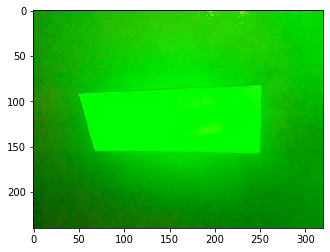

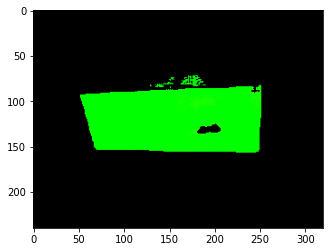

In [5]:
th = bgr_to_rgb(cv2.imread("tape.jpeg"))
plt.imshow(th)
plt.show()

imgyuv = skimage.color.rgb2yuv(th)

knownyuv = skimage.color.rgb2yuv(th[100:150, 75:225])

knownyuv = np.reshape(knownyuv, (-1, 3))

red_mean_color_yuv = knownyuv.mean(axis = 0)
red_stddev_color_yuv = knownyuv.std(axis = 0)

scale = 4
low_threshold = np.array([0.0,
                          red_mean_color_yuv[1] - scale * red_stddev_color_yuv[1],
                          red_mean_color_yuv[2] - scale * red_stddev_color_yuv[2]])

high_threshold = np.array([1.0,
                          red_mean_color_yuv[1] + scale * red_stddev_color_yuv[1],
                          red_mean_color_yuv[2] + scale * red_stddev_color_yuv[2]])

background_mask = np.all((imgyuv > low_threshold) * (imgyuv < high_threshold), axis=2)
background_mask = np.where(background_mask, 1, 0)
background_mask = np.expand_dims(background_mask, 2)

th = th*background_mask
cv2.imwrite("mid.jpeg", th)
plt.imshow(th)
plt.show()

In [10]:
HALF = 125

def filt(name):
  im = bgr_to_rgb(cv2.imread(name))

  imgyuv = skimage.color.rgb2yuv(im)

  scale = 4
  low_threshold = np.array([0.0,
                          red_mean_color_yuv[1] - scale * red_stddev_color_yuv[1],
                          red_mean_color_yuv[2] - scale * red_stddev_color_yuv[2]])

  high_threshold = np.array([1.0,
                          red_mean_color_yuv[1] + scale * red_stddev_color_yuv[1],
                          red_mean_color_yuv[2] + scale * red_stddev_color_yuv[2]])

  background_mask = np.all((imgyuv > low_threshold) * (imgyuv < high_threshold), axis=2)
  background_mask = np.where(background_mask, 1, 0)
  background_mask = np.expand_dims(background_mask, 2)

  im = im*background_mask
  cv2.imwrite("mid.jpeg", im)

def a(name):
  img = cv2.imread(name)

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = img[0:HALF,:]
  #img = cv2.blur(img, (10, 10))

  imgray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  ret, thresh = cv2.threshold(imgray, 10, 240, 0)

  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  img = skimage.color.yuv2rgb(img)

  c = find_contour(contours)
  x, y, w, h = cv2.boundingRect(c)
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

  plt.imshow(img)
  plt.show()

def find_contour(contours):
  if len(contours) == 0: return 0
  largest = contours[0]
  for c in contours:
    if (cv2.contourArea(c) > cv2.contourArea(largest)):
        largest = c
  return largest

#a("mid.jpeg")

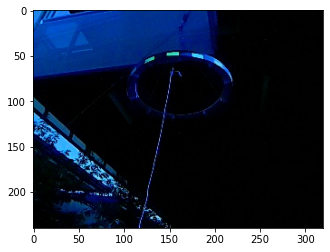

error: ignored

In [11]:
plt.imshow(cv2.imread("center.jpeg"))
plt.show()

filt("center.jpeg")
a("mid.jpeg")

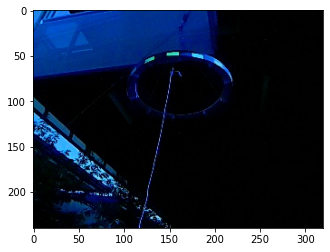

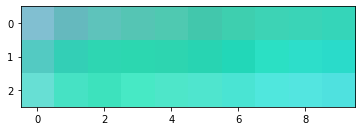

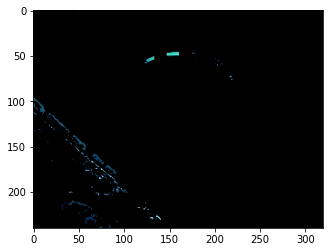

In [5]:
th = cv2.imread("center.jpeg")
plt.imshow(th)
plt.show()

imgyuv = skimage.color.rgb2yuv(th)

knownyuv = skimage.color.rgb2yuv(th[47:50, 148:158])
plt.imshow(th[47:50, 148:158])
plt.show()

knownyuv = np.reshape(knownyuv, (-1, 3))

red_mean_color_yuv = knownyuv.mean(axis = 0)
red_stddev_color_yuv = knownyuv.std(axis = 0)

scale = 4
low_threshold = np.array([0.0,
                          red_mean_color_yuv[1] - scale * red_stddev_color_yuv[1],
                          red_mean_color_yuv[2] - scale * red_stddev_color_yuv[2]])

high_threshold = np.array([1.0,
                          red_mean_color_yuv[1] + scale * red_stddev_color_yuv[1],
                          red_mean_color_yuv[2] + scale * red_stddev_color_yuv[2]])

background_mask = np.all((imgyuv > low_threshold) * (imgyuv < high_threshold), axis=2)
background_mask = np.where(background_mask, 1, 0)
background_mask = np.expand_dims(background_mask, 2)

th = th*background_mask
cv2.imwrite("mid.jpeg", th)
plt.imshow(th)
plt.show()

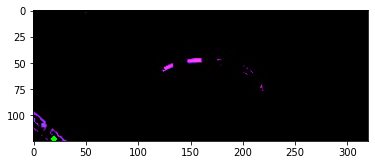

In [38]:
a("mid.jpeg")